In [25]:
import numpy as np
import pandas as pd 
from skimage.io import imread, imsave
from skimage import draw
import matplotlib.pyplot as plt
import os
import pdb
import pickle

In [26]:
# Get image names
train = os.listdir('../../data/train')
print(len(train))

104070


In [27]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [28]:
# Load masks
masks = pd.read_csv('../../data/train_ship_segmentations.csv')
print(len(masks))

131030


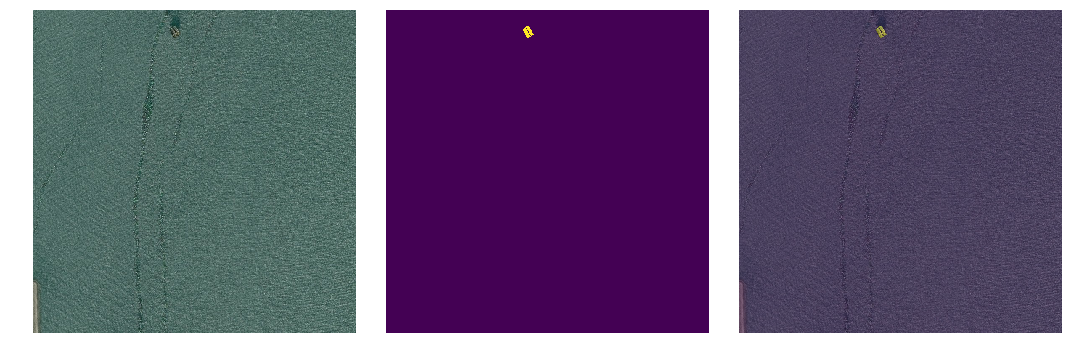

In [29]:
# One example
ImageId = train[3]

img = imread('../../data/train/' + ImageId)
img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [30]:
def box_to_mask(box,mask_size=(768,768)):
    R0 = box[0]
    C0 = box[1]
    L1 = box[2]
    L2 = box[3]
    theta = box[4]
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    box = 0.5*np.array([[L1,L2],[L1,-L2],[-L1,-L2],[-L1,L2]]).T
    box_rot = np.dot(R,box)
    rr, cc = draw.polygon(R0+box_rot[0,:],C0+box_rot[1,:],shape=mask_size)
    mask = np.zeros(mask_size,dtype=int)
    mask[rr,cc] = 1
    return mask

def mask_to_box(mask):
    mask_size = mask.shape[0]
    row_non_zero, col_non_zero = np.nonzero(mask)
    
    ############ Find corner coordinates ###########
    # Note: Because the pixel values are discrete, it will make
    # more sense to start from top-left or top-right depending on the orientation
    # Top coordinate
    min_row = np.min(row_non_zero)
    min_row_idxs = np.where(row_non_zero==min_row)
    top_coord_1 = min_row, np.min(col_non_zero[min_row_idxs])  # top-left
    top_coord_2 = min_row, np.max(col_non_zero[min_row_idxs])  # top-right
    # Bottom coordinate
    max_row = np.max(row_non_zero)
    max_row_idxs = np.where(row_non_zero==max_row)
    bottom_coord_1 = max_row, np.max(col_non_zero[max_row_idxs])  # bottom-right
    bottom_coord_2 = max_row, np.min(col_non_zero[max_row_idxs])  # bottom-left
    # Left coordinate
    min_col = np.min(col_non_zero)
    min_col_idxs = np.where(col_non_zero==min_col)
    left_coord_1 = np.max(row_non_zero[min_col_idxs]), min_col  # left-bottom
    left_coord_2 = np.min(row_non_zero[min_col_idxs]), min_col  # left-top
    # Right coordinate
    max_col = np.max(col_non_zero)
    max_col_idxs = np.where(col_non_zero==max_col)
    right_coord_1 = np.min(row_non_zero[max_col_idxs]), max_col  # right-top
    right_coord_2 = np.max(row_non_zero[max_col_idxs]), max_col  # right-bottom
    # Stack coordinates and draw masks from boxes (polygons)
    rect_coords_1 = np.array([top_coord_1,left_coord_1,bottom_coord_1,right_coord_1])
    rect_coords_2 = np.array([top_coord_2,left_coord_2,bottom_coord_2,right_coord_2])
    rr_1,cc_1 = draw.polygon(rect_coords_1[:,0],rect_coords_1[:,1], shape=None)
    mask1 = np.zeros_like(mask)
    mask1[rr_1,cc_1] = 1
    rr_2,cc_2 = draw.polygon(rect_coords_2[:,0],rect_coords_2[:,1], shape=None)
    mask2 = np.zeros_like(mask)
    mask2[rr_2,cc_2] = 1
    # Whichever polygon mask is closest to raw pixel mask, choose those coordinates
    IOU1 = np.sum(mask & mask1)/np.sum(mask | mask1)
    IOU2 = np.sum(mask & mask2)/np.sum(mask | mask2)
    if IOU1 > IOU2:
        rect_coords = rect_coords_1
    else:
        rect_coords = rect_coords_2 

    ############ Find box parameters ###########
    # Start from box corner which is furthest from borders
    pivot_corner = np.argmax(np.amin(np.minimum(rect_coords, mask_size-rect_coords),axis=1))
    rect_coords = np.roll(rect_coords,-pivot_corner,axis=0)
    # vectors directed towards neighboring corners
    vec1 = rect_coords[1,:]-rect_coords[0,:]
    vec2 = rect_coords[0,:]-rect_coords[3,:]
    # find midpoints from pivot_corner, vec1 and vec2
    midpoint = rect_coords[0,:] + vec1/2 - vec2/2
    # find box lengths
    L1 = np.sqrt(np.sum(np.power(vec1,2))) 
    L2 = np.sqrt(np.sum(np.power(vec2,2))) 
    longer = np.argmax([L1,L2])
    if L1 >= L2:
        vec = vec1 
    else:
        vec = vec2
        L = L1
        L1 = L2
        L2 = L
    # find orientation of longest vec
    theta = np.arctan(vec[1]/vec[0])
    # construct box vector
    box = [midpoint[0],midpoint[1],L1,L2,theta]
    return box



In [33]:
save_new_image = True
new_image_directory = '../../data_small/train/'
all_image_ids = []
num_ships = []
box_image_ids = []
R = []
C = []
L1 = []
L2 = []
theta = []
for i, ImageId in enumerate(train):
    if i % 1000 == 0:
        print(i)
    if i == 200:    
        break
    img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()
    all_image_ids.append(ImageId)
    if img_masks[0] is np.nan:
        num_ships.append(0)
        if save_new_image:
            img = imread('../../data/train/' + ImageId)
            imsave(new_image_directory + ImageId,img)
    else:
        img = imread('../../data/train/' + ImageId)
        if save_new_image:
            imsave(new_image_directory + ImageId,img)
        img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()
        num_ships.append(len(img_masks))

        for j in range(len(img_masks)):
            mask = rle_decode(img_masks[j])
            box_vec = mask_to_box(mask)
            box_image_ids.append(ImageId)
            C.append(box_vec[0])  # THIS IS A MISTAKE BUT GO WITH IT
            R.append(box_vec[1])
            L1.append(box_vec[2])
            L2.append(box_vec[3])
            theta.append(box_vec[4])
            if False:
                # construct rotated box for sanity check
                mask = box_to_mask(box_vec)
                img[mask] = 255

                fig, axarr = plt.subplots(1,2,figsize=(12, 6))
                axarr[0].axis('off')
                axarr[0].imshow(img)
                axarr[1].axis('off')
                axarr[1].imshow(mask)
                plt.show()
                pdb.set_trace()

0


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/train_small/0005d01c8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/train_small/000969125.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/train_small/000bd9ac4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/train_small/000c150b0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/train

In [37]:
outfile = '../../data_small/box_data.pickle'
data_out = {'box_image_ids': box_image_ids,
           'L1': np.array(L1),
           'L2': np.array(L2),
           'theta': np.array(theta),
           'C0': np.array(C),
           'R0': np.array(R),
           'all_image_ids': all_image_ids,
           'num_ships': np.array(num_ships)}

with open(outfile, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data_out, f, pickle.HIGHEST_PROTOCOL)